### Helper Functions

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a function to unnormalize and show the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU")

# 1. Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

# 2. Load the pre-trained model and modify the final layer
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)  # Move model to the chosen device

# 3. Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 4. Fine-tune the model

loss_values = []

for epoch in range(5):
    print(epoch)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            loss_values.append(avg_loss)
            running_loss = 0.0

print('Finished Fine-tuning')

# 5. Test the model on test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Save entire model
torch.save(model, 'entire_fine_tuned_resnet18.pth')


In [24]:


# 5. Load the saved model
model = torch.load('entire_fine_tuned_resnet18.pth')
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# 6. Test the model on test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move data to the chosen device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 92 %


### Shuffling the Test Loader so that every time I sample I get different Images

In [41]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True)

Files already downloaded and verified


### Visualize true vs predicted labels on random samples

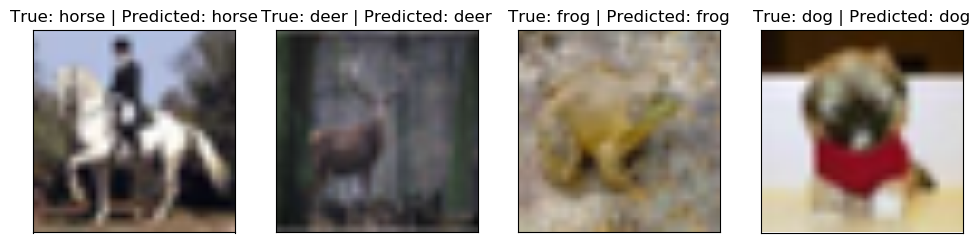

In [42]:


# Define the classes of CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


# Get a random sample from the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels for the sample
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)


# Plot the images along with true and predicted labels
fig = plt.figure(figsize=(12, 4))
for idx in range(4):  # Assuming a batch size of 4
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx].item()]} | Predicted: {classes[predicted[idx].item()]}")

plt.show()


IndexError: index 4 is out of bounds for dimension 0 with size 4

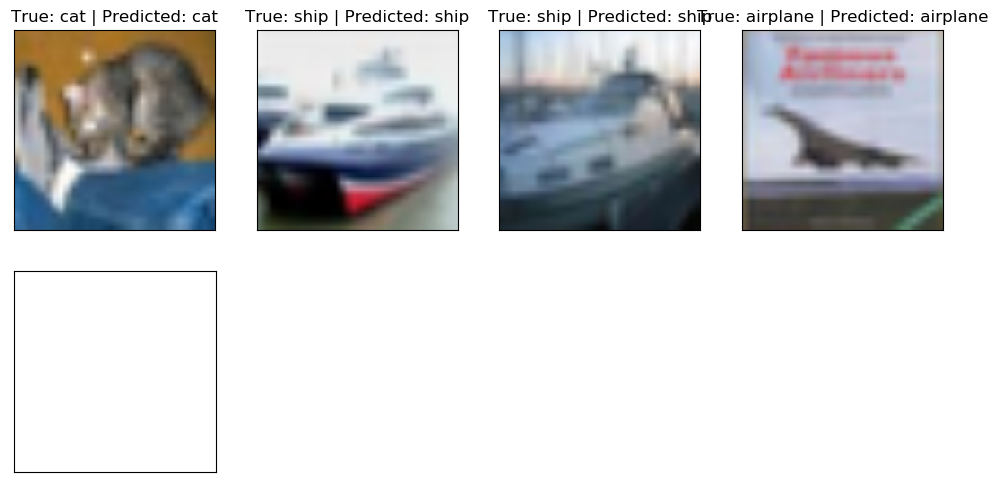

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define the classes of CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# Define a function to unnormalize and show the image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a random sample from the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels for the sample
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plot the images along with true and predicted labels
fig = plt.figure(figsize=(12, 12))  # Adjust size for more images
for idx in range(16):  # Adjust loop range for 16 images
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])  # 4x4 grid
    imshow(images[idx])
    ax.set_title(f"True: {classes[labels[idx].item()]} | Predicted: {classes[predicted[idx].item()]}")

plt.tight_layout()  # Ensure there's enough space between images
plt.show()


In [29]:
break 

SyntaxError: 'break' outside loop (371449011.py, line 4)

In [2]:

# Load entire model
model = torch.load('entire_fine_tuned_resnet18.pth')


In [3]:
pwd

'/Users/aordorica/Documents/UofT/MIE 1517/A2'

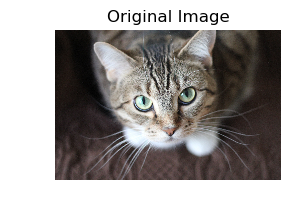

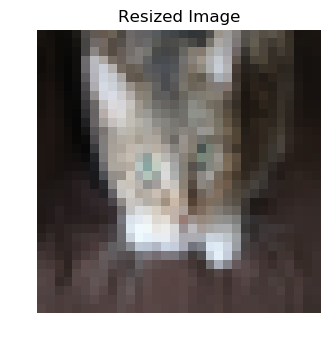

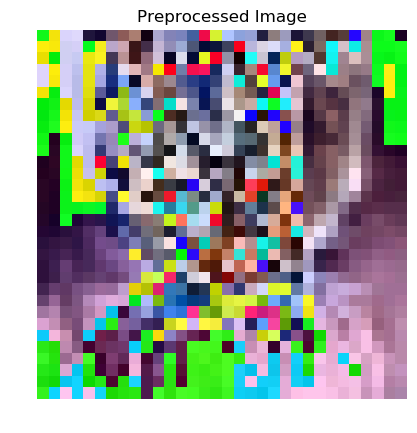

Predicted Class: truck


In [22]:
from PIL import Image

# Assuming model and transform (from previous code) are already defined

# def predict_image(image_path, model, transform, classes):
#     # Load the image
#     image = Image.open(image_path).convert('RGB')
    
#     # Preprocess the image
#     image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
#     # Move the tensor and model to the appropriate device
#     image_tensor = image_tensor.to(device)
#     model = model.to(device)
    
#     # Inference
#     with torch.no_grad():
#         outputs = model(image_tensor)
#         _, predicted_idx = torch.max(outputs, 1)
#         predicted_class = classes[predicted_idx[0].item()]
    
#     return predicted_class

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def predict_image(image_path, model, classes):
    model = model.cpu()
    from PIL import Image
    image = Image.open(image_path)
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    resized_image = transforms.Resize((32, 32))(image)
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.title("Resized Image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
    # Define the transformations: resize to 32x32, convert to tensor, and normalize
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    # Load the image using PIL and apply transformations

    image = Image.open(image_path)
    image_tensor = transform(image)
    
    image_tensor = image_tensor.cpu()
    C
    # Visualize the preprocessed image
    plt.imshow(transforms.ToPILImage()(image_tensor))
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()

    # Model prediction
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    # Make sure the model is in evaluation mode and use it for prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        return classes[predicted[0].item()]

# Test the function with an example
image_path = "cat.jpg"
predicted_class = predict_image(image_path, model, classes)
print(f"Predicted Class: {predicted_class}")


# Load class names of CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [11]:
# ls

In [12]:
# Make a prediction
image_path = "cat.jpg"
predicted_class = predict_image(image_path, model, transform, classes)
print(f"Predicted Class: {predicted_class}")

Predicted Class: deer


In [13]:
# Make a prediction
image_path = "cat2.jpg"
predicted_class = predict_image(image_path, model, transform, classes)
print(f"Predicted Class: {predicted_class}")

Predicted Class: deer


In [14]:
# Make a prediction
image_path = "dog.jpg"
predicted_class = predict_image(image_path, model, transform, classes)
print(f"Predicted Class: {predicted_class}")

Predicted Class: deer


In [ ]:
from PIL import Image

# Assuming model and transform (from previous code) are already defined

def predict_image(image_path, model, transform, classes):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Check if GPU is available and move the tensor there
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
        model = model.cuda()
    
    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = classes[predicted_idx[0].item()]
    
    return predicted_class

# Load class names of CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Make a prediction
image_path = "path_to_your_image.jpg"
predicted_class = predict_image(image_path, model, transform, classes)
print(f"Predicted Class: {predicted_class}")
